In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import time
import os
from joblib import Memory
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Base_Path = "/content/drive/MyDrive/capstone_project_fire_risk"

In [ ]:
import os

print(f"Current working directory: {os.getcwd()}")
os.chdir(Base_Path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content
Current working directory: /content/drive/MyDrive/capstone_project_fire_risk


In [ ]:
uef_df= gpd.read_file(f'{Base_Path}/uniteevaluationfonciere/uniteevaluationfonciere.shp', encoding='utf-8')

In [ ]:
uef_df.head()

,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,NOM_RUE,SUITE_DEBU,MUNICIPALI,ETAGE_HORS,NOMBRE_LOG,ANNEE_CONS,CODE_UTILI,LETTRE_DEB,LETTRE_FIN,LIBELLE_UT,CATEGORIE_,MATRICULE8,SUPERFICIE,SUPERFIC_1,NO_ARROND_,geometry
0,01038405,3577,3577,avenue Atwater (MTL+WMT),None,50,NaN,NaN,1983,1921,None,None,Stationnement intérieur (condo),Condominium,9739-83-9737-8-001-0431,2,NaN,REM19,"POLYGON ((297829.682 5039309.256, 297830.361 5..."
1,05213144,5211,5211,rue du Sureau (PFD),105,50,1.0,1.0,2012,1000,None,None,Logement,Condominium,7941-06-3037-4-001-0004,69,68.0,REM31,"POLYGON ((279029.064 5041684.534, 279039.924 5..."
2,01036349,3550,3550,rue de la Montagne (MTL),109,50,3.0,1.0,1983,1000,None,None,Logement,Condominium,9840-31-8010-6-001-0005,133,127.0,REM19,"POLYGON ((298357.161 5040101.378, 298393.693 5..."
3,05189527,1200,1200,rue Saint-Alexandre (MTL),511,50,1.0,1.0,1963,1000,None,None,Logement,Condominium,9940-55-8522-7-001-0257,16,62.0,REM19,"POLYGON ((299541.566 5040531.245, 299550.843 5..."
4,01037334,1254,1254,rue Saint-Marc (MTL),61,50,1.0,1.0,1914,1000,None,None,Logement,Condominium,9839-51-6255-9-001-0013,16,82.0,REM19,"POLYGON ((298555.055 5039168.035, 298576.898 5..."


In [ ]:
uef_df.isnull().sum()
uef_df = uef_df.drop_duplicates(keep='first')
uef_df = uef_df.dropna(subset=['NOM_RUE', 'CIVIQUE_DE', 'CIVIQUE_FI'])
uef_df['NOM_RUE'] = uef_df['NOM_RUE'].str.replace(r'\(.*?\)', '', regex=True)
uef_df = uef_df.drop_duplicates(subset=['CIVIQUE_FI', 'NOM_RUE', 'MUNICIPALI'], keep='first')

#uef_df = uef_df.dropna()
uef_df.loc[uef_df['CIVIQUE_DE'].isnull(), 'CIVIQUE_FI'] = 0
uef_df.loc[:, 'ANNEE_CONS'] = pd.to_datetime(uef_df['ANNEE_CONS'], format='%Y', errors='coerce')
uef_df.loc[:, 'ANNEE_CONS'] = uef_df['ANNEE_CONS'].fillna(pd.NaT)
uef_df = uef_df.dropna(subset=['ANNEE_CONS'])
uef_df.loc[:, 'CATEGORIE_'] = uef_df['CATEGORIE_'].astype('category')

<ipython-input-82-085f778ab780>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1983-01-01 00:00:00', '2012-01-01 00:00:00', '1983-01-01 00:00:00',
 '1963-01-01 00:00:00', '1914-01-01 00:00:00', '1949-01-01 00:00:00',
 '1892-01-01 00:00:00', '1929-01-01 00:00:00', '1965-01-01 00:00:00',
 '1927-01-01 00:00:00',
 ...
 '1993-01-01 00:00:00', '1992-01-01 00:00:00', '1994-01-01 00:00:00',
                 'NaT', '1962-01-01 00:00:00', '1946-01-01 00:00:00',
 '1902-01-01 00:00:00', '1983-01-01 00:00:00', '1956-01-01 00:00:00',
 '1986-01-01 00:00:00']
Length: 357346, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  uef_df.loc[:, 'ANNEE_CONS'] = pd.to_datetime(uef_df['ANNEE_CONS'], format='%Y', errors='coerce')


In [ ]:
municipality_mapping = {
    2: 'Baie-D\'Urfé',
    3: 'Beaconsfield',
    4: 'Côte-Saint-Luc',
    5: 'Dollard-Des Ormeaux',
    6: 'Dorval',
    7: 'Hampstead',
    10: 'Kirkland',
    9: 'L\'Île-Dorval',
    13: 'Mont-Royal',
    50: 'Montréal',
    14: 'Montréal-Est',
    15: 'Montréal-Ouest',
    20: 'Pointe-Claire',
    23: 'Sainte-Anne-de-Bellevue',
    22: 'Senneville',
    29: 'Westmount'
}

uef_df['MUNICIPALI'] = pd.to_numeric(uef_df['MUNICIPALI'], errors='coerce')

uef_df['MUNICIPALITY_NAME'] = uef_df['MUNICIPALI'].map(municipality_mapping)


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
#np.unique(uef_df.LIBELLE_UT.values)

In [ ]:
uef_df.columns

Index(['ID_UEV', 'CIVIQUE_DE', 'CIVIQUE_FI', 'NOM_RUE', 'SUITE_DEBU',
       'MUNICIPALI', 'ETAGE_HORS', 'NOMBRE_LOG', 'ANNEE_CONS', 'CODE_UTILI',
       'LETTRE_DEB', 'LETTRE_FIN', 'LIBELLE_UT', 'CATEGORIE_', 'MATRICULE8',
       'SUPERFICIE', 'SUPERFIC_1', 'NO_ARROND_', 'geometry',
       'MUNICIPALITY_NAME'],
      dtype='object')

In [ ]:
uef_df.head()

,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,NOM_RUE,SUITE_DEBU,MUNICIPALI,ETAGE_HORS,NOMBRE_LOG,ANNEE_CONS,CODE_UTILI,LETTRE_DEB,LETTRE_FIN,LIBELLE_UT,CATEGORIE_,MATRICULE8,SUPERFICIE,SUPERFIC_1,NO_ARROND_,geometry,MUNICIPALITY_NAME
0,01038405,3577,3577,avenue Atwater,None,50,NaN,NaN,1983-01-01,1921,None,None,Stationnement intérieur (condo),Condominium,9739-83-9737-8-001-0431,2,NaN,REM19,"POLYGON ((297829.682 5039309.256, 297830.361 5...",Montréal
1,05213144,5211,5211,rue du Sureau,105,50,1.0,1.0,2012-01-01,1000,None,None,Logement,Condominium,7941-06-3037-4-001-0004,69,68.0,REM31,"POLYGON ((279029.064 5041684.534, 279039.924 5...",Montréal
2,01036349,3550,3550,rue de la Montagne,109,50,3.0,1.0,1983-01-01,1000,None,None,Logement,Condominium,9840-31-8010-6-001-0005,133,127.0,REM19,"POLYGON ((298357.161 5040101.378, 298393.693 5...",Montréal
3,05189527,1200,1200,rue Saint-Alexandre,511,50,1.0,1.0,1963-01-01,1000,None,None,Logement,Condominium,9940-55-8522-7-001-0257,16,62.0,REM19,"POLYGON ((299541.566 5040531.245, 299550.843 5...",Montréal
4,01037334,1254,1254,rue Saint-Marc,61,50,1.0,1.0,1914-01-01,1000,None,None,Logement,Condominium,9839-51-6255-9-001-0013,16,82.0,REM19,"POLYGON ((298555.055 5039168.035, 298576.898 5...",Montréal


In [ ]:
french_to_english_column_names = {
    'ID_UEV': 'UEV_ID',
    'CIVIQUE_DE': 'CIVIC_START',
    'CIVIQUE_FI': 'CIVIC_END',
    'NOM_RUE': 'STREET_NAME',
    'SUITE_DEBU': 'UNIT_NUMBER_START',
    'ETAGE_HORS': 'FLOORS_ABOVE_GROUND',
    'NOMBRE_LOG': 'NUMBER_OF_UNITS',
    'ANNEE_CONS': 'CONSTRUCTION_YEAR',
    'CODE_UTILI': 'USE_CODE',
    'LETTRE_DEB': 'LETTER_START',
    'LETTRE_FIN': 'LETTER_END',
    'LIBELLE_UT': 'USE_DESCRIPTION',
    'CATEGORIE_': 'UEF_CATEGORY',
    'MATRICULE8': 'LAND_ROLL_NUMBER',
    'SUPERFICIE': 'LAND_AREA',
    'SUPERFIC_1': 'BUILDING_AREA',
    'NO_ARROND_': 'DISTRICT_ID',
    'MUNICIPALI': 'MUNICIPALITY_CODE'
    }

uef_df = uef_df.rename(columns=french_to_english_column_names)

In [ ]:
# create a new column to calculate building age from the CONSTRUCTION_YEAR column
uef_df['BUILDING_AGE'] = (pd.Timestamp('now').year - uef_df['CONSTRUCTION_YEAR'].dt.year)
uef_df.loc[uef_df['CONSTRUCTION_YEAR'].dt.year < 1600, 'BUILDING_AGE'] = -1


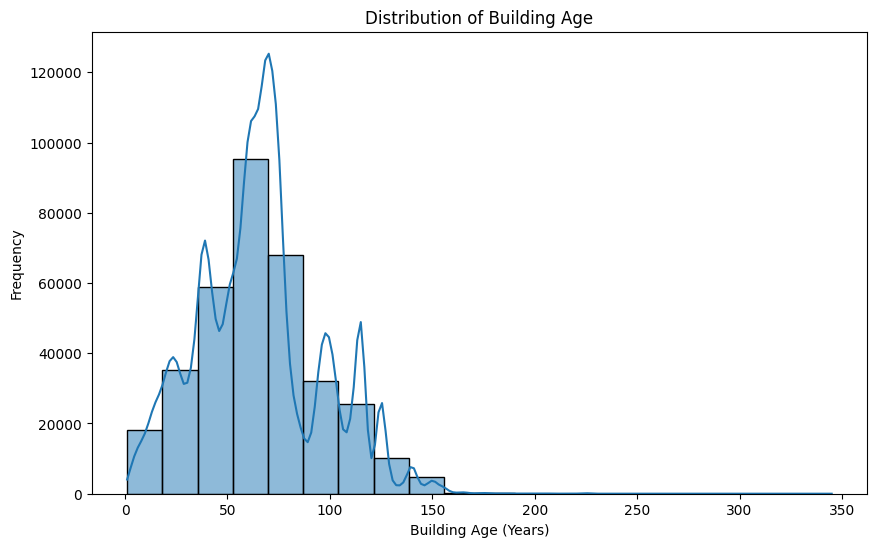

In [ ]:
# Distribution Plot with Bigger Bins
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(uef_df['BUILDING_AGE'], kde=True, bins=20)  # Increase bins for bigger binning
plt.title('Distribution of Building Age')
plt.xlabel('Building Age (Years)')
plt.ylabel('Frequency')
plt.show()

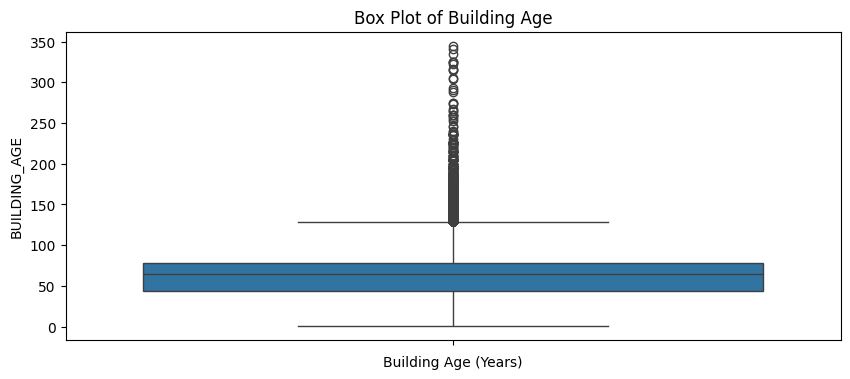

In [ ]:
# Box Plot
plt.figure(figsize=(10, 4))  # Adjust figure size as needed
sns.boxplot(y=uef_df['BUILDING_AGE'])
plt.title('Box Plot of Building Age')
plt.xlabel('Building Age (Years)')
plt.show()

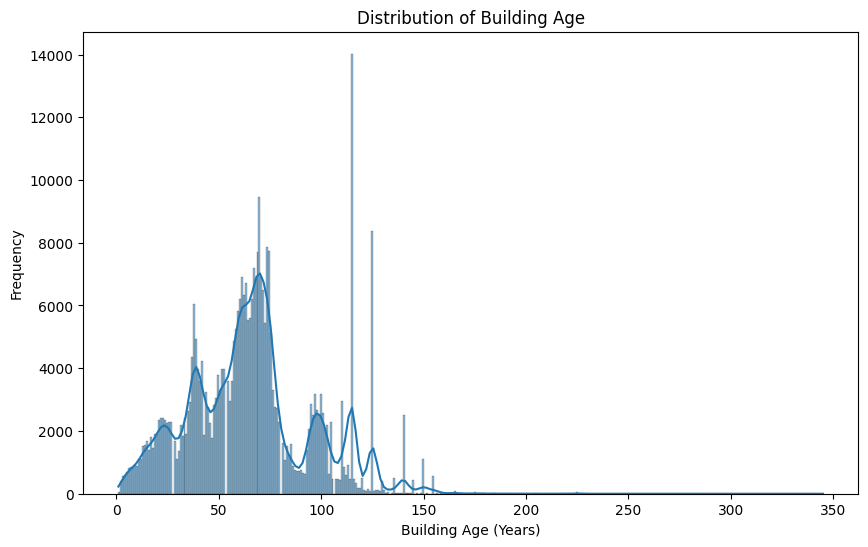

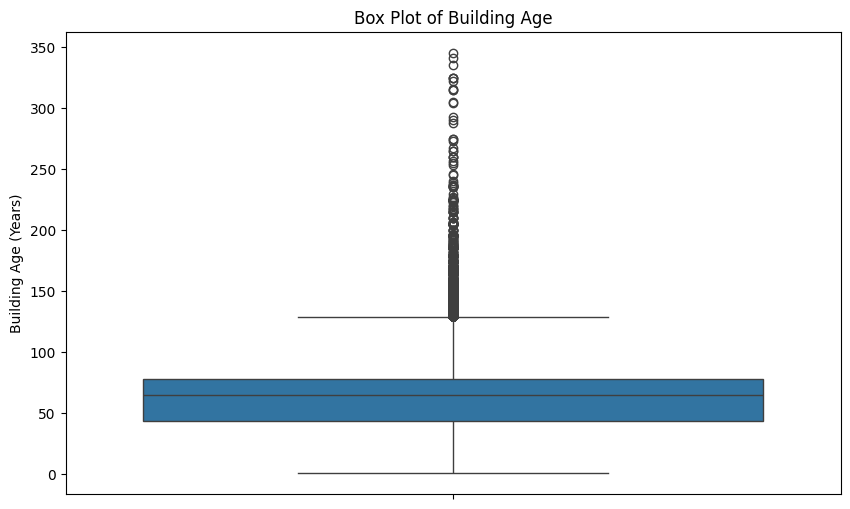

Number of outliers: 6438
Outliers:


,UEV_ID,CIVIC_START,CIVIC_END,STREET_NAME,UNIT_NUMBER_START,MUNICIPALITY_CODE,FLOORS_ABOVE_GROUND,NUMBER_OF_UNITS,CONSTRUCTION_YEAR,USE_CODE,...,LETTER_END,USE_DESCRIPTION,UEF_CATEGORY,LAND_ROLL_NUMBER,LAND_AREA,BUILDING_AREA,DISTRICT_ID,geometry,MUNICIPALITY_NAME,BUILDING_AGE
6,01043207,3809,3811,rue Clark,None,50,2.0,2.0,1892-01-01,1000,...,None,Logement,Régulier,9841-86-2796-8-000-0000,128,164.0,REM21,"POLYGON ((298824.658 5041686.156, 298819.496 5...",Montréal,133
48,01005023,543,543,rue Sainte-Madeleine,None,50,2.0,1.0,1885-01-01,1000,...,None,Logement,Régulier,0037-38-3777-2-000-0000,293,221.0,REM20,"POLYGON ((300334.147 5037892.506, 300341.402 5...",Montréal,140
49,01005026,557,557,rue Sainte-Madeleine,None,50,2.0,1.0,1875-01-01,1000,...,None,Logement,Régulier,0037-38-1778-2-000-0000,136,111.0,REM20,"POLYGON ((300314.458 5037863.392, 300314.976 5...",Montréal,150
60,01000565,2086,2088,rue Jeanne-Mance,None,50,3.0,4.0,1885-01-01,1000,...,None,Logement,Régulier,9940-39-1681-2-000-0000,320,321.0,REM19,"POLYGON ((299301.291 5040966.618, 299324.244 5...",Montréal,140
63,01005355,493,493,avenue Elm,None,29,2.0,1.0,1894-01-01,1000,...,None,Logement,Régulier,9738-58-3051-4-000-0000,235,271.0,REM99,"POLYGON ((297535.489 5038866.646, 297541.989 5...",Westmount,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510252,01021278,1720,1726,rue Saint-Denis,None,50,3.0,1.0,1893-01-01,1000,...,None,Logement,Régulier,9941-77-3516-6-000-0000,1117,1034.0,REM19,"POLYGON ((299758.599 5041730.991, 299731.953 5...",Montréal,132
510928,01045323,5065,5067,rue Turcot,None,50,2.0,2.0,1885-01-01,1000,...,None,Logement,Régulier,9736-47-5886-8-000-0000,206,93.0,REM20,"POLYGON ((297464.492 5036776.479, 297446.731 5...",Montréal,140
511197,05266804,3713,3713,rue Sainte-Émilie,None,50,1.0,2.0,1880-01-01,1000,...,None,Logement,Condominium,9837-56-5615-8-000-0005,36,75.0,REM20,"POLYGON ((298543.626 5037606.221, 298555.597 5...",Montréal,145
511684,01045631,4285,4285,rue Saint-Jacques,None,50,3.0,6.0,1895-01-01,1000,...,None,Logement,Régulier,9737-84-7041-9-000-0000,343,379.0,REM20,"POLYGON ((297886.771 5037431.739, 297877.256 5...",Montréal,130


In [ ]:
# Distribution plot of building age
plt.figure(figsize=(10, 6))
sns.histplot(uef_df['BUILDING_AGE'], kde=True)
plt.title('Distribution of Building Age')
plt.xlabel('Building Age (Years)')
plt.ylabel('Frequency')
plt.show()

# Box plot of building age
plt.figure(figsize=(10, 6))
sns.boxplot(y=uef_df['BUILDING_AGE'])
plt.title('Box Plot of Building Age')
plt.ylabel('Building Age (Years)')
plt.show()

# Identify outliers using IQR method
Q1 = uef_df['BUILDING_AGE'].quantile(0.25)
Q3 = uef_df['BUILDING_AGE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = uef_df[(uef_df['BUILDING_AGE'] < lower_bound) | (uef_df['BUILDING_AGE'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")
print("Outliers:")
outliers


In [ ]:
# Count buildings with age -1
count = len(uef_df[uef_df['BUILDING_AGE'] == -1])

# Print the count
print(f"Number of buildings with age -1: {count}")

Number of buildings with age -1: 0


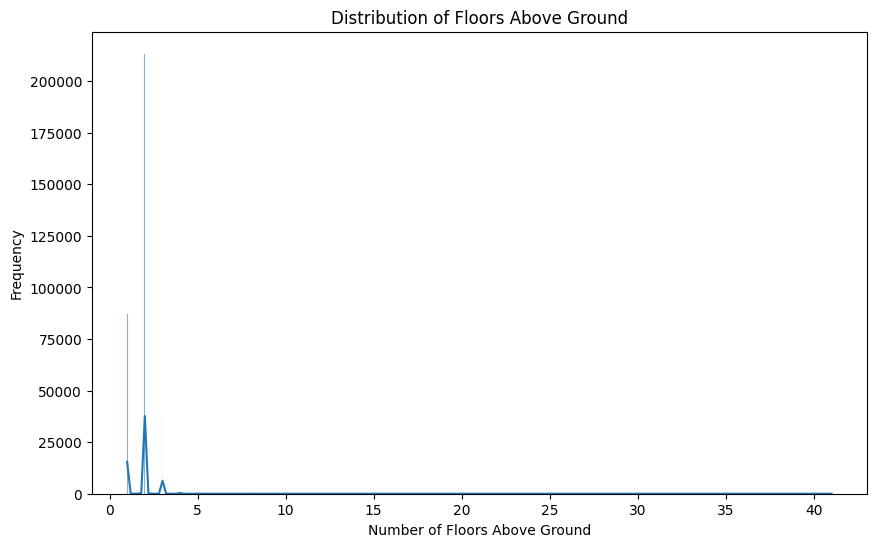

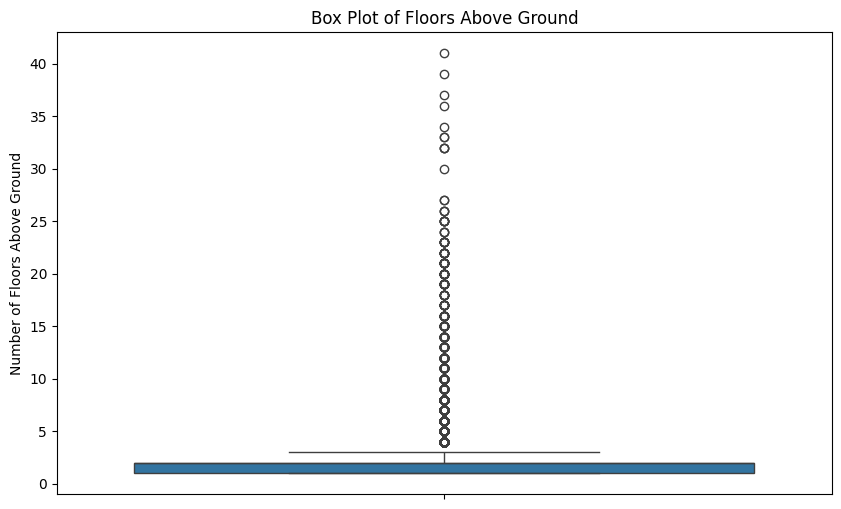

In [ ]:
# Distribution Plot of FLOORS_ABOVE_GROUND
plt.figure(figsize=(10, 6))
sns.histplot(uef_df['FLOORS_ABOVE_GROUND'], kde=True)
plt.title('Distribution of Floors Above Ground')
plt.xlabel('Number of Floors Above Ground')
plt.ylabel('Frequency')
plt.show()

# Box Plot of FLOORS_ABOVE_GROUND
plt.figure(figsize=(10, 6))
sns.boxplot(y=uef_df['FLOORS_ABOVE_GROUND'])
plt.title('Box Plot of Floors Above Ground')
plt.ylabel('Number of Floors Above Ground')
plt.show()

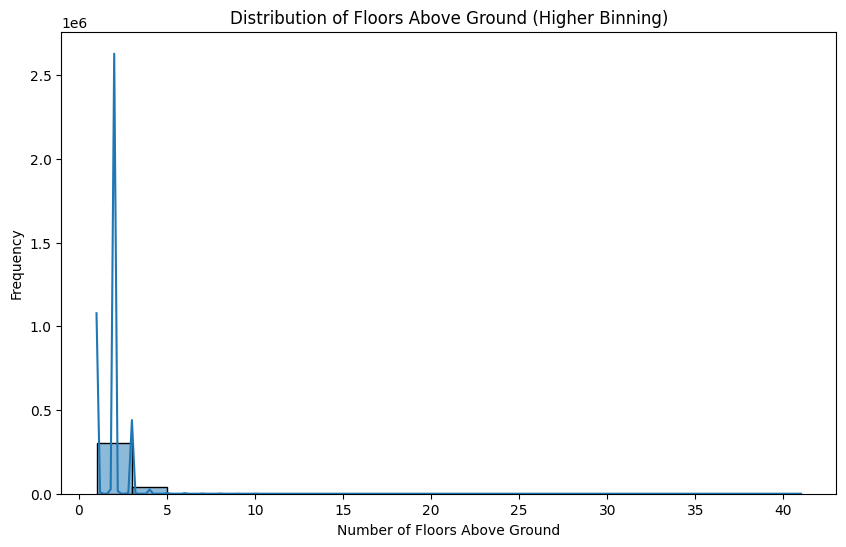

In [ ]:
# Distribution Plot of FLOORS_ABOVE_GROUND with higher binning
plt.figure(figsize=(10, 6))
sns.histplot(uef_df['FLOORS_ABOVE_GROUND'], kde=True, bins=20)  # Increased bins
plt.title('Distribution of Floors Above Ground (Higher Binning)')
plt.xlabel('Number of Floors Above Ground')
plt.ylabel('Frequency')
plt.show()


In [ ]:
uef_df.head()

,UEV_ID,CIVIC_START,CIVIC_END,STREET_NAME,UNIT_NUMBER_START,MUNICIPALITY_CODE,FLOORS_ABOVE_GROUND,NUMBER_OF_UNITS,CONSTRUCTION_YEAR,USE_CODE,...,LETTER_END,USE_DESCRIPTION,UEF_CATEGORY,LAND_ROLL_NUMBER,LAND_AREA,BUILDING_AREA,DISTRICT_ID,geometry,MUNICIPALITY_NAME,BUILDING_AGE
0,01038405,3577,3577,avenue Atwater,None,50,NaN,NaN,1983-01-01,1921,...,None,Stationnement intérieur (condo),Condominium,9739-83-9737-8-001-0431,2,NaN,REM19,"POLYGON ((297829.682 5039309.256, 297830.361 5...",Montréal,42
1,05213144,5211,5211,rue du Sureau,105,50,1.0,1.0,2012-01-01,1000,...,None,Logement,Condominium,7941-06-3037-4-001-0004,69,68.0,REM31,"POLYGON ((279029.064 5041684.534, 279039.924 5...",Montréal,13
2,01036349,3550,3550,rue de la Montagne,109,50,3.0,1.0,1983-01-01,1000,...,None,Logement,Condominium,9840-31-8010-6-001-0005,133,127.0,REM19,"POLYGON ((298357.161 5040101.378, 298393.693 5...",Montréal,42
3,05189527,1200,1200,rue Saint-Alexandre,511,50,1.0,1.0,1963-01-01,1000,...,None,Logement,Condominium,9940-55-8522-7-001-0257,16,62.0,REM19,"POLYGON ((299541.566 5040531.245, 299550.843 5...",Montréal,62
4,01037334,1254,1254,rue Saint-Marc,61,50,1.0,1.0,1914-01-01,1000,...,None,Logement,Condominium,9839-51-6255-9-001-0013,16,82.0,REM19,"POLYGON ((298555.055 5039168.035, 298576.898 5...",Montréal,111


In [ ]:
# Keep only the specified columns
columns_to_keep = ['FLOORS_ABOVE_GROUND', 'USE_CODE', 'USE_DESCRIPTION', 'BUILDING_AGE', 'geometry']
uef_df = uef_df[columns_to_keep]
uef_df.head()


,FLOORS_ABOVE_GROUND,USE_CODE,USE_DESCRIPTION,BUILDING_AGE,geometry
0,NaN,1921,Stationnement intérieur (condo),42,"POLYGON ((297829.682 5039309.256, 297830.361 5..."
1,1.0,1000,Logement,13,"POLYGON ((279029.064 5041684.534, 279039.924 5..."
2,3.0,1000,Logement,42,"POLYGON ((298357.161 5040101.378, 298393.693 5..."
3,1.0,1000,Logement,62,"POLYGON ((299541.566 5040531.245, 299550.843 5..."
4,1.0,1000,Logement,111,"POLYGON ((298555.055 5039168.035, 298576.898 5..."


<Axes: >

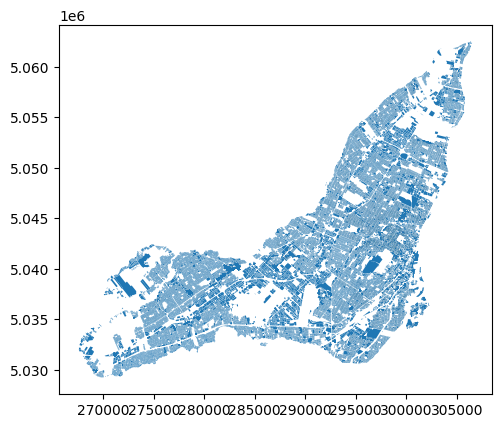

In [ ]:
uef_df.plot()

In [ ]:
print(uef_df.isnull().sum())


FLOORS_ABOVE_GROUND    9187
USE_CODE                  0
USE_DESCRIPTION           0
BUILDING_AGE              0
geometry                  0
dtype: int64


In [ ]:
from pandas import isna

# Select the columns of interest
cols_to_check = uef_df.columns

# Create a subset DataFrame with only the columns to check
subset_df = uef_df[cols_to_check]

# Calculate the overlap of null values between all pairs of columns
for col1 in cols_to_check:
    for col2 in cols_to_check:
        if col1 != col2:  # Avoid comparing a column to itself
            # Find rows where both columns have null values
            overlap_count = len(subset_df[(isna(subset_df[col1])) & (isna(subset_df[col2]))])

            # Print the overlap count
            print(f"Overlap between {col1} and {col2}: {overlap_count}")

Overlap between FLOORS_ABOVE_GROUND and USE_CODE: 0
Overlap between FLOORS_ABOVE_GROUND and USE_DESCRIPTION: 0
Overlap between FLOORS_ABOVE_GROUND and BUILDING_AGE: 0
Overlap between FLOORS_ABOVE_GROUND and geometry: 0
Overlap between USE_CODE and FLOORS_ABOVE_GROUND: 0
Overlap between USE_CODE and USE_DESCRIPTION: 0
Overlap between USE_CODE and BUILDING_AGE: 0
Overlap between USE_CODE and geometry: 0
Overlap between USE_DESCRIPTION and FLOORS_ABOVE_GROUND: 0
Overlap between USE_DESCRIPTION and USE_CODE: 0
Overlap between USE_DESCRIPTION and BUILDING_AGE: 0
Overlap between USE_DESCRIPTION and geometry: 0
Overlap between BUILDING_AGE and FLOORS_ABOVE_GROUND: 0
Overlap between BUILDING_AGE and USE_CODE: 0
Overlap between BUILDING_AGE and USE_DESCRIPTION: 0
Overlap between BUILDING_AGE and geometry: 0
Overlap between geometry and FLOORS_ABOVE_GROUND: 0
Overlap between geometry and USE_CODE: 0
Overlap between geometry and USE_DESCRIPTION: 0
Overlap between geometry and BUILDING_AGE: 0


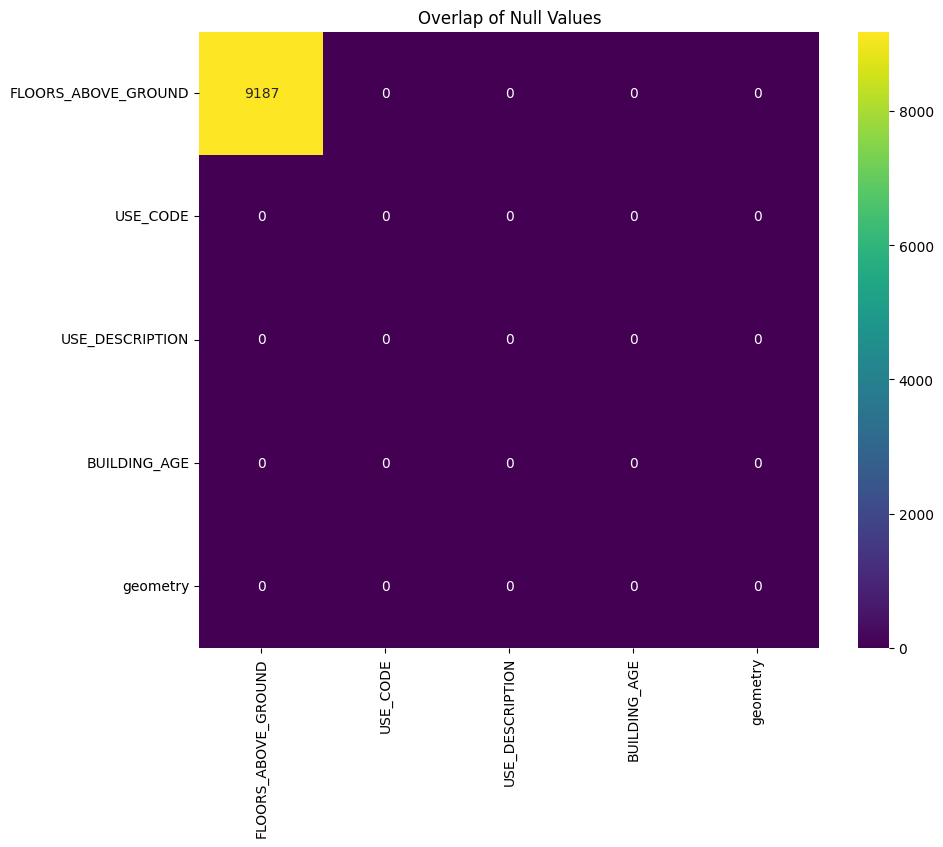

In [ ]:
# Create a subset DataFrame with only the columns to check
cols_to_check = uef_df.columns
subset_df = uef_df[cols_to_check]

# Create a heatmap showing the overlap of null values
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(subset_df.isnull().astype(int).T.dot(subset_df.isnull().astype(int)),
            cmap="viridis", annot=True, fmt="d",
            xticklabels=cols_to_check, yticklabels=cols_to_check)
plt.title("Overlap of Null Values")
plt.show()

In [ ]:
# Drop duplicates based on all columns, keeping the first occurrence
uef_df = uef_df.drop_duplicates(keep='first')


In [ ]:
len(uef_df)

324099

In [ ]:
#unique_uses = uef_df[['USE_CODE', 'USE_DESCRIPTION']].drop_duplicates()
#unique_uses.to_excel('USE_CODE_DESCRIPTION.xlsx', index=False)

In [ ]:
# Used copilot to generate a simpler categorization of USE DESCRIPTION
try:
    df_use_codes = pd.read_excel('USE_CODE_DESCRIPTION_Categorized.xlsx')
    print(df_use_codes.head())
except FileNotFoundError:
    print("Error: 'USE_CODE_DESCRIPTION_categorized.xlsx' not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

df_use_codes = df_use_codes.rename(columns={'Category': 'USE_CAT'})


   USE_CODE                  USE_DESCRIPTION     Category
0      1921  Stationnement intérieur (condo)        Other
1      1000                         Logement  Residential
2      5010              Immeuble commercial   Commercial
3      1922  Stationnement extérieur (condo)        Other
4      6000               Immeuble à bureaux       Office


In [ ]:
uef_df.head(
)

,FLOORS_ABOVE_GROUND,USE_CODE,USE_DESCRIPTION,BUILDING_AGE,geometry
0,NaN,1921,Stationnement intérieur (condo),42,"POLYGON ((297829.682 5039309.256, 297830.361 5..."
1,1.0,1000,Logement,13,"POLYGON ((279029.064 5041684.534, 279039.924 5..."
2,3.0,1000,Logement,42,"POLYGON ((298357.161 5040101.378, 298393.693 5..."
3,1.0,1000,Logement,62,"POLYGON ((299541.566 5040531.245, 299550.843 5..."
4,1.0,1000,Logement,111,"POLYGON ((298555.055 5039168.035, 298576.898 5..."


In [ ]:
uef_df['USE_CODE'] = pd.to_numeric(uef_df['USE_CODE'], errors='coerce')

try:
    uef_df = pd.merge(uef_df, df_use_codes, on='USE_CODE', how='left')
    #uef_df_merges = pd.merge(uef_df, df_use_codes, on=['USE_CODE', 'USE_DESCRIPTION'], how='left')
    print(uef_df.head())
except KeyError:
    print("Error: 'USE_CODE' column not found in one or both DataFrames.")
except Exception as e:
    print(f"An error occurred during the merge: {e}")


   FLOORS_ABOVE_GROUND  USE_CODE                USE_DESCRIPTION_x  \
0                  NaN      1921  Stationnement intérieur (condo)   
1                  1.0      1000                         Logement   
2                  3.0      1000                         Logement   
3                  1.0      1000                         Logement   
4                  1.0      1000                         Logement   

   BUILDING_AGE                                           geometry  \
0            42  POLYGON ((297829.682 5039309.256, 297830.361 5...   
1            13  POLYGON ((279029.064 5041684.534, 279039.924 5...   
2            42  POLYGON ((298357.161 5040101.378, 298393.693 5...   
3            62  POLYGON ((299541.566 5040531.245, 299550.843 5...   
4           111  POLYGON ((298555.055 5039168.035, 298576.898 5...   

                 USE_DESCRIPTION_y      USE_CAT  
0  Stationnement intérieur (condo)        Other  
1                         Logement  Residential  
2             

In [ ]:
uef_df = uef_df.rename(columns={'USE_DESCRIPTION_x': 'USE_DESCRIPTION'})

In [ ]:
uef_df['BUILDING_AGE'] = pd.to_numeric(uef_df['BUILDING_AGE'], errors='coerce')
uef_df['FLOORS_ABOVE_GROUND'] = pd.to_numeric(uef_df['FLOORS_ABOVE_GROUND'], errors='coerce')

In [ ]:
uef_df.columns

Index(['FLOORS_ABOVE_GROUND', 'USE_CODE', 'USE_DESCRIPTION', 'BUILDING_AGE',
       'geometry', 'USE_DESCRIPTION_y', 'USE_CAT'],
      dtype='object')

In [ ]:
uef_df = uef_df.drop(columns=['USE_DESCRIPTION_y'])


In [ ]:
uef_df.head()

,FLOORS_ABOVE_GROUND,USE_CODE,USE_DESCRIPTION,BUILDING_AGE,geometry,USE_CAT
0,NaN,1921,Stationnement intérieur (condo),42,"POLYGON ((297829.682 5039309.256, 297830.361 5...",Other
1,1.0,1000,Logement,13,"POLYGON ((279029.064 5041684.534, 279039.924 5...",Residential
2,3.0,1000,Logement,42,"POLYGON ((298357.161 5040101.378, 298393.693 5...",Residential
3,1.0,1000,Logement,62,"POLYGON ((299541.566 5040531.245, 299550.843 5...",Residential
4,1.0,1000,Logement,111,"POLYGON ((298555.055 5039168.035, 298576.898 5...",Residential


In [ ]:
output_shp_path = f"{Base_Path}/property_assessment_cleaned.shp"

uef_df.to_file(output_shp_path, driver='ESRI Shapefile', encoding='utf-8')

<ipython-input-51-bd2ac3d8a4e3>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  uef_df.to_file(output_shp_path, driver='ESRI Shapefile', encoding='utf-8')
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'CIVIC_START' to 'CIVIC_STAR'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'STREET_NAME' to 'STREET_NAM'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UNIT_NUMBER_START' to 'UNIT_NUMBE'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'MUNICIPALITY_CODE' to 'MUNICIPALI'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'FLOORS_ABOVE_GROUND' to 'FLOORS_ABO'
  ogr_write(
/usr/loc

In [ ]:
output_shp_path = "property_assessment_cleaned.shp"

uef_df.to_file(output_shp_path, driver='ESRI Shapefile', encoding='utf-8')

<ipython-input-120-ba93230c9753>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  uef_df.to_file(output_shp_path, driver='ESRI Shapefile', encoding='utf-8')
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'FLOORS_ABOVE_GROUND' to 'FLOORS_ABO'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'USE_DESCRIPTION' to 'USE_DESCRI'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'BUILDING_AGE' to 'BUILDING_A'
  ogr_write(


In [ ]:
from google.colab import files

files.download('property_assessment_cleaned.shp')
files.download('property_assessment_cleaned.cpg')
files.download('property_assessment_cleaned.dbf')
files.download('property_assessment_cleaned.prj')
files.download('property_assessment_cleaned.shx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>